# Lecture 7: Forward and Futures Contracts

## MIT 15.401 — Finance Theory I (Prof. Andrew Lo)

---

**Video:** [MIT OCW — Forward and Futures Contracts](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/forward-and-futures-contracts/)

**Readings:** Brealey, Myers, and Allen — Chapter 27

---

This session introduces **derivative securities** — financial instruments whose value is derived from an underlying asset. We begin with the simplest derivatives: **forward contracts** and **futures contracts**, which are agreements to exchange an asset at a future date for a price agreed today.

The key insight is that forward/futures prices are determined by **no-arbitrage** — the same principle that priced bonds in Sessions 4–5. If you can replicate the same payoff two ways (forward contract vs. "buy and store"), the two methods must cost the same. This gives us the fundamental **cost-of-carry** pricing formula.

Lo motivates the lecture with a practical question: your US firm sells machine tools in Germany and Brazil. Exchange rate fluctuations create revenue risk. How can you **hedge** this? The answer: derivatives.

## Table of Contents

1. [Motivation — Why Derivatives?](#1-motivation)
2. [Forward Contracts](#2-forwards)
3. [Futures Contracts](#3-futures)
4. [Marking to Market and Margin](#4-marking)
5. [Valuation — The Cost-of-Carry Model](#5-valuation)
6. [Applications: Gold, Gasoline, Stock Indices](#6-applications)
7. [Hedging with Index Futures](#7-hedging)
8. [Exercises](#8-exercises)

In [3]:
# ============================================================
# Setup
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams.update({
    'figure.figsize': (10, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 12,
    'lines.linewidth': 2,
})

print("Libraries loaded successfully.")

Libraries loaded successfully.


---

<a id='1-motivation'></a>
## 1. Motivation — Why Derivatives?

### Lo's Opening Questions

Lo opens with three motivating questions:

1. **Currency hedging:** Your US firm sells machine tools in Germany (€) and Brazil (R\$). Exchange rate fluctuations swing your revenues. How do you hedge?

2. **Convertible bonds:** Your firm issues bonds convertible into 20 shares per 1,000 USD face. What interest rate should you pay?

3. **Real options:** You can buy a copper mine for 400K USD (1M kg of copper at 2.20 USD/kg, mining cost 2 USD/kg). You can delay extraction one year. How valuable is the option to delay?

Each question involves **uncertainty about future prices** — and each can be addressed with derivatives.

### The Case for Hedging

Lo presents two opposing views:

**View 1: Hedging is irrelevant** (Modigliani-Miller). Derivatives are zero-NPV financial transactions. Diversified shareholders don't care about firm-specific risk.

**View 2: Hedging creates value.** It ensures cash availability for positive-NPV investments, reduces distress costs, and improves evaluation of operating performance.

**Real-world practice:** Guay and Kothari (2003) found that 57% of large US firms use derivatives, but programs are surprisingly small — even a 3σ event produces only 15M USD in payoff for the average firm (vs. 735M USD in operating cash flow).

### Caterpillar: A Cautionary Tale

Lo shows how the strong dollar in the early 1980s devastated Caterpillar's sales. As the dollar strengthened from ~80 to ~130 on the trade-weighted index (1980–1985), Caterpillar's sales fell from 9B to 6B USD — a 33% decline caused largely by currency movements, not operating performance.

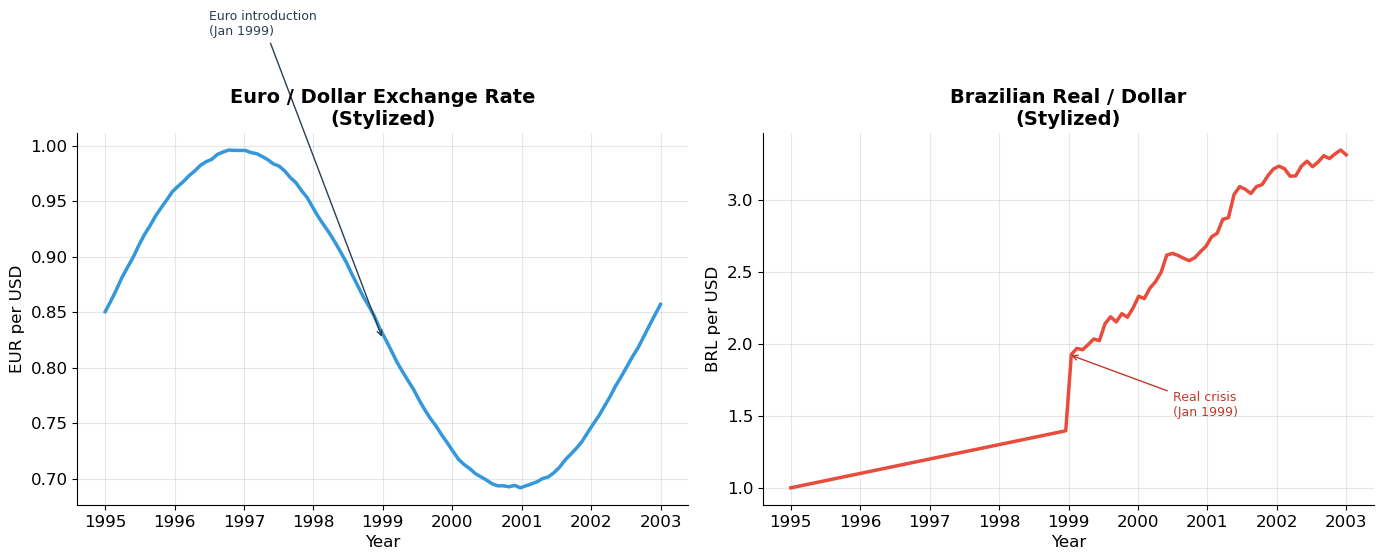

For a US firm selling in local currencies, exchange rate volatility
directly translates to revenue volatility — even when unit sales are stable.
Forward/futures contracts allow firms to lock in future exchange rates.


In [5]:
# ============================================================
# Exchange Rate Volatility and Hedging Motivation
# ============================================================
# Stylized EUR/USD and BRL/USD data (based on Lo's slides, 1995-2003)
np.random.seed(42)
years = np.linspace(1995, 2003, 100)

# EUR/USD: start ~0.75 (DEM equivalent), peak ~1.2, then stabilize
eur_usd = 0.85 + 0.15 * np.sin((years - 1995) * 0.8) + 0.05 * np.cumsum(np.random.normal(0, 0.02, 100))
eur_usd = np.clip(eur_usd, 0.5, 1.5)

# BRL/USD: stable ~1.0 until 1999 crisis, then jumps to ~3.0+
brl_usd = np.where(years < 1999, 1.0 + 0.1 * (years - 1995),
                    2.0 + 0.3 * (years - 1999) + np.cumsum(np.random.normal(0, 0.05, 100)) * (years > 1999))
brl_usd = np.clip(brl_usd, 0.8, 3.8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(years, eur_usd, color='#3498db', linewidth=2.5)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('EUR per USD', fontsize=12)
ax1.set_title('Euro / Dollar Exchange Rate\n(Stylized)', fontsize=14, fontweight='bold')
ax1.annotate('Euro introduction\n(Jan 1999)', xy=(1999, eur_usd[50]),
            xytext=(1996.5, 1.1), fontsize=9, color='#2c3e50',
            arrowprops=dict(arrowstyle='->', color='#2c3e50'))

ax2.plot(years, brl_usd, color='#e74c3c', linewidth=2.5)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('BRL per USD', fontsize=12)
ax2.set_title('Brazilian Real / Dollar\n(Stylized)', fontsize=14, fontweight='bold')
ax2.annotate('Real crisis\n(Jan 1999)', xy=(1999, brl_usd[50]),
            xytext=(2000.5, 1.5), fontsize=9, color='#c0392b',
            arrowprops=dict(arrowstyle='->', color='#c0392b'))

plt.tight_layout()
plt.show()

print("For a US firm selling in local currencies, exchange rate volatility")
print("directly translates to revenue volatility — even when unit sales are stable.")
print("Forward/futures contracts allow firms to lock in future exchange rates.")

---

<a id='2-forwards'></a>
## 2. Forward Contracts

### Definition

A **forward contract** is a commitment to purchase (or sell) a given amount of a commodity or asset at a **future date**, at a **price agreed today**.

Key terminology:
- **Forward price** $F_{0,T}$: the price fixed today for exchange at time $T$
- **Long position** (buyer): agrees to BUY at $F_{0,T}$ — profits if the spot price rises above $F$
- **Short position** (seller): agrees to SELL at $F_{0,T}$ — profits if the spot price falls below $F$

### Features

| Feature | Description |
|---------|-------------|
| **Customized** | Negotiated privately between two parties |
| **OTC** | Not traded on exchanges |
| **No initial cash flow** | No money changes hands until maturity |
| **Counterparty risk** | Risk that the other side defaults |

### Lo's Soybean Example

Current soybean price: \$160/ton. A tofu manufacturer needs 1,000 tons in 3 months and enters a 3-month forward at \$165/ton.

**Outcomes at maturity:**
- If spot price = \$180: Manufacturer buys at \$165, saves \$15/ton (forward was valuable)
- If spot price = \$150: Manufacturer buys at \$165, overpays by \$15/ton (but had certainty)

### Payoff at Maturity

The payoff of a forward contract at maturity $T$ depends on the spot price $S_T$:

$$\text{Long payoff} = S_T - F_{0,T}$$
$$\text{Short payoff} = F_{0,T} - S_T$$

Note: the payoffs sum to zero — forwards are a **zero-sum game** between long and short.

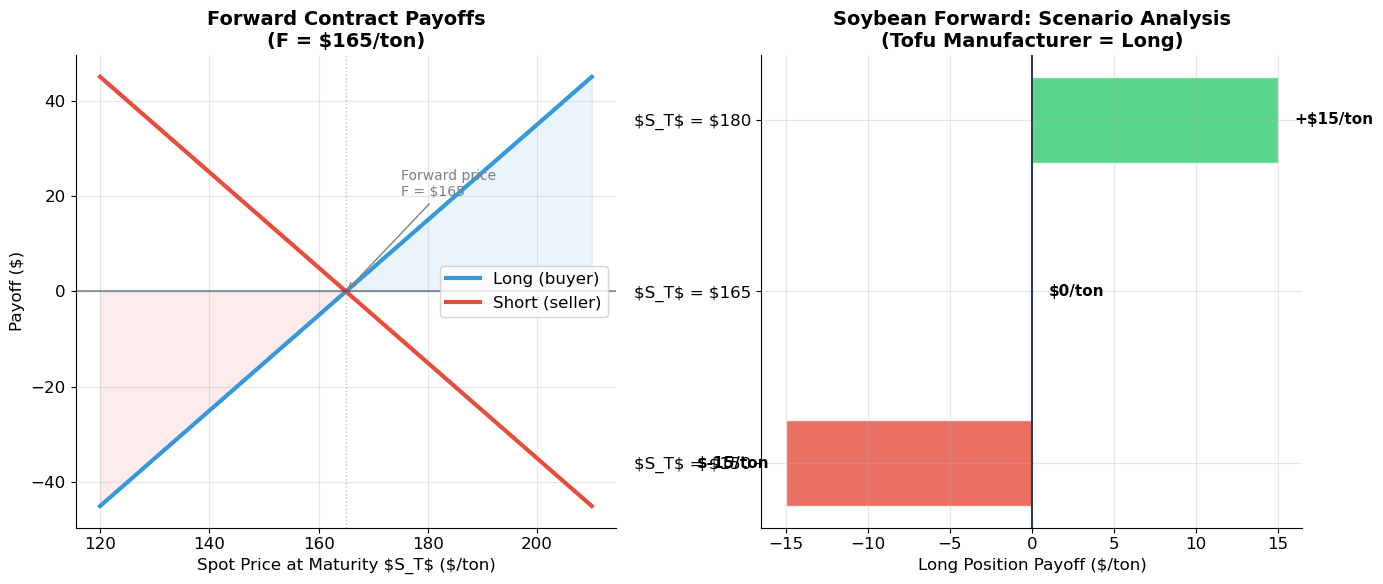

Key insight: Forward contracts are zero-sum games.
Long gains = Short losses, and vice versa.
No money changes hands at initiation — the contract is free to enter.


In [7]:
# ============================================================
# Forward Contract Payoff Diagrams
# ============================================================
# ▶ MODIFY AND RE-RUN
F = 165   # Forward price ($/ton)
S_range = np.linspace(120, 210, 200)
# ============================================================

long_payoff = S_range - F
short_payoff = F - S_range

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Long and short payoffs
ax1.plot(S_range, long_payoff, color='#3498db', linewidth=3, label='Long (buyer)')
ax1.plot(S_range, short_payoff, color='#e74c3c', linewidth=3, label='Short (seller)')
ax1.axhline(y=0, color='#2c3e50', linewidth=1.5, alpha=0.5)
ax1.axvline(x=F, color='gray', linewidth=1, linestyle=':', alpha=0.5)
ax1.fill_between(S_range, 0, long_payoff, where=long_payoff > 0, alpha=0.1, color='#3498db')
ax1.fill_between(S_range, 0, long_payoff, where=long_payoff < 0, alpha=0.1, color='#e74c3c')

ax1.set_xlabel('Spot Price at Maturity $S_T$ ($/ton)', fontsize=12)
ax1.set_ylabel('Payoff ($)', fontsize=12)
ax1.set_title(f'Forward Contract Payoffs\n(F = ${F}/ton)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=12)

ax1.annotate(f'Forward price\nF = ${F}', xy=(F, 0), xytext=(F + 10, 20),
            fontsize=10, color='gray',
            arrowprops=dict(arrowstyle='->', color='gray'))

# Right: Soybean example scenarios
scenarios = [
    ('$S_T$ = $150', 150, 'Manufacturer\noverpaid by $15/ton\n(but had certainty)'),
    ('$S_T$ = $165', 165, 'Break-even\n(paid forward price)'),
    ('$S_T$ = $180', 180, 'Manufacturer\nsaved $15/ton\n(forward was valuable)'),
]

for name, S, note in scenarios:
    long_pf = S - F
    color = '#2ecc71' if long_pf > 0 else '#e74c3c' if long_pf < 0 else '#e67e22'
    ax2.barh(name, long_pf, color=color, alpha=0.8, edgecolor='white', height=0.5)
    sign = '+' if long_pf > 0 else ''
    ax2.text(long_pf + (1 if long_pf >= 0 else -1), name,
            f'{sign}${long_pf}/ton', va='center',
            ha='left' if long_pf >= 0 else 'right', fontsize=11, fontweight='bold')

ax2.axvline(x=0, color='#2c3e50', linewidth=1.5)
ax2.set_xlabel('Long Position Payoff ($/ton)', fontsize=12)
ax2.set_title('Soybean Forward: Scenario Analysis\n(Tofu Manufacturer = Long)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Key insight: Forward contracts are zero-sum games.")
print("Long gains = Short losses, and vice versa.")
print("No money changes hands at initiation — the contract is free to enter.")

---

<a id='3-futures'></a>
## 3. Futures Contracts

### Limitations of Forwards

Forward contracts suffer from two problems:
1. **Illiquidity:** hard to exit a customized bilateral agreement before maturity
2. **Counterparty risk:** if the other side defaults, you're unprotected

### Futures: The Exchange-Traded Solution

A **futures contract** is an exchange-traded, standardized, forward-like contract that is **marked to market daily**.

| Feature | Forward | Futures |
|---------|---------|---------|
| Trading | OTC (bilateral) | Exchange (centralized) |
| Standardization | Customized | Standardized (quantity, dates) |
| Counterparty risk | Direct exposure | Clearing house guarantee |
| Cash flows | Settlement at maturity | Daily settlement (mark-to-market) |
| Liquidity | Low | High |
| Margin | None (typically) | Required |

### Lo's NYMEX Crude Oil Example (Slide 13)

NYMEX crude oil (light) futures for December 2007 delivery:
- Price: \$75.06/bbl (as of July 27, 2007)
- Contract size: 1,000 barrels
- Tick size: \$0.01/bbl = \$10/contract
- Initial margin: \$4,050
- Maintenance margin: \$3,000

No cash changes hands today. The buyer (long) profits if oil prices rise; the seller (short) profits if they fall.

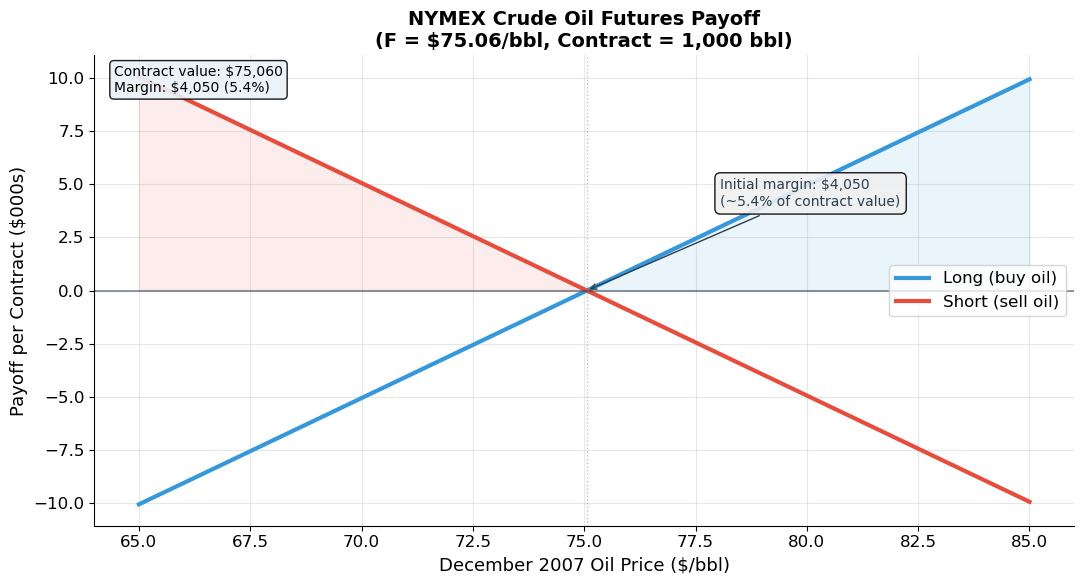

In [9]:
# ============================================================
# Futures Payoff Diagram — Crude Oil Example
# ============================================================
F_oil = 75.06  # $/bbl
S_oil = np.linspace(65, 85, 200)
contract_size = 1000  # barrels per contract

long_payoff_oil = (S_oil - F_oil) * contract_size
short_payoff_oil = (F_oil - S_oil) * contract_size

fig, ax = plt.subplots(figsize=(11, 6))

ax.plot(S_oil, long_payoff_oil / 1000, color='#3498db', linewidth=3, label='Long (buy oil)')
ax.plot(S_oil, short_payoff_oil / 1000, color='#e74c3c', linewidth=3, label='Short (sell oil)')
ax.axhline(y=0, color='#2c3e50', linewidth=1.5, alpha=0.5)
ax.axvline(x=F_oil, color='gray', linewidth=1, linestyle=':', alpha=0.5)

ax.fill_between(S_oil, 0, long_payoff_oil / 1000, where=long_payoff_oil > 0, alpha=0.1, color='#3498db')
ax.fill_between(S_oil, 0, short_payoff_oil / 1000, where=short_payoff_oil > 0, alpha=0.1, color='#e74c3c')

ax.set_xlabel('December 2007 Oil Price ($/bbl)', fontsize=13)
ax.set_ylabel('Payoff per Contract ($000s)', fontsize=13)
ax.set_title(f'NYMEX Crude Oil Futures Payoff\n(F = ${F_oil}/bbl, Contract = {contract_size:,} bbl)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=12)

# Annotate margin
ax.annotate(f'Initial margin: $4,050\n(~5.4% of contract value)',
            xy=(F_oil, 0), xytext=(F_oil + 3, 4),
            fontsize=10, color='#2c3e50',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#f0f0f0', alpha=0.9),
            arrowprops=dict(arrowstyle='->', color='#2c3e50'))

contract_value = F_oil * contract_size
margin_pct = 4050 / contract_value * 100
ax.text(0.02, 0.98, f'Contract value: ${contract_value:,.0f}\nMargin: ${4050:,} ({margin_pct:.1f}%)',
        transform=ax.transAxes, va='top', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='#eaf2f8', alpha=0.9))

plt.tight_layout()
plt.show()

---

<a id='4-marking'></a>
## 4. Marking to Market and Margin

### How Daily Settlement Works

Unlike forward contracts (which settle only at maturity), futures are **marked to market daily**: gains and losses are credited/debited to margin accounts each day.

### Lo's Live Cattle Example (Slide 15)

You buy 10 December live-cattle contracts on the CME at \$0.7455/lb. Each contract covers 40,000 lb.

**Day 1 (position opened):**
- Position value: $0.7455 \times 10 \times 40{,}000 = \$298{,}200$
- No cash changes hands (you post margin)

**Day 2 (price drops to \$0.7435/lb):**
- New position value: $0.7435 \times 10 \times 40{,}000 = \$297{,}400$
- **Daily loss: \$800** (debited from your margin account)

### Why Marking to Market Matters

Daily settlement serves two critical functions:
1. **Reduces counterparty risk:** losses are collected daily, so defaults are limited to one day's move
2. **The clearing house** stands between buyer and seller, guaranteeing both sides

### Margin Mechanics

- **Initial margin:** deposit required to open a position (typically 5–20% of contract value)
- **Maintenance margin:** minimum balance; if equity falls below this, you receive a **margin call** and must deposit additional funds
- If you fail to meet a margin call, your position is **liquidated**

MARKING TO MARKET — 5 NYMEX Crude Oil Contracts
Entry: $75.06/bbl, Contract: 1,000 bbl, Position: 5,000 bbl
Initial margin: $20,250,  Maintenance margin: $15,000
  Day      Price    Daily Δ    Daily P&L    Cumul P&L   Margin Bal          Status
-------------------------------------------------------------------------------------
    1      73.76      -1.30       -6,514       -6,514       20,250 MARGIN CALL +$6,514
    2      74.95      +1.20       +5,984         -530       26,234              OK
    3      75.29      +0.34       +1,698       +1,168       27,932              OK
    4      73.49      -1.81       -9,038       -7,870       18,894              OK
    5      72.79      -0.69       -3,472      -11,341       15,423 Getting close...
    6      74.77      +1.98       +9,909       -1,433       25,331              OK
    7      71.86      -2.91      -14,560      -15,993       20,250 MARGIN CALL +$9,479
    8      71.35      -0.51       -2,573      -18,566       17,677             

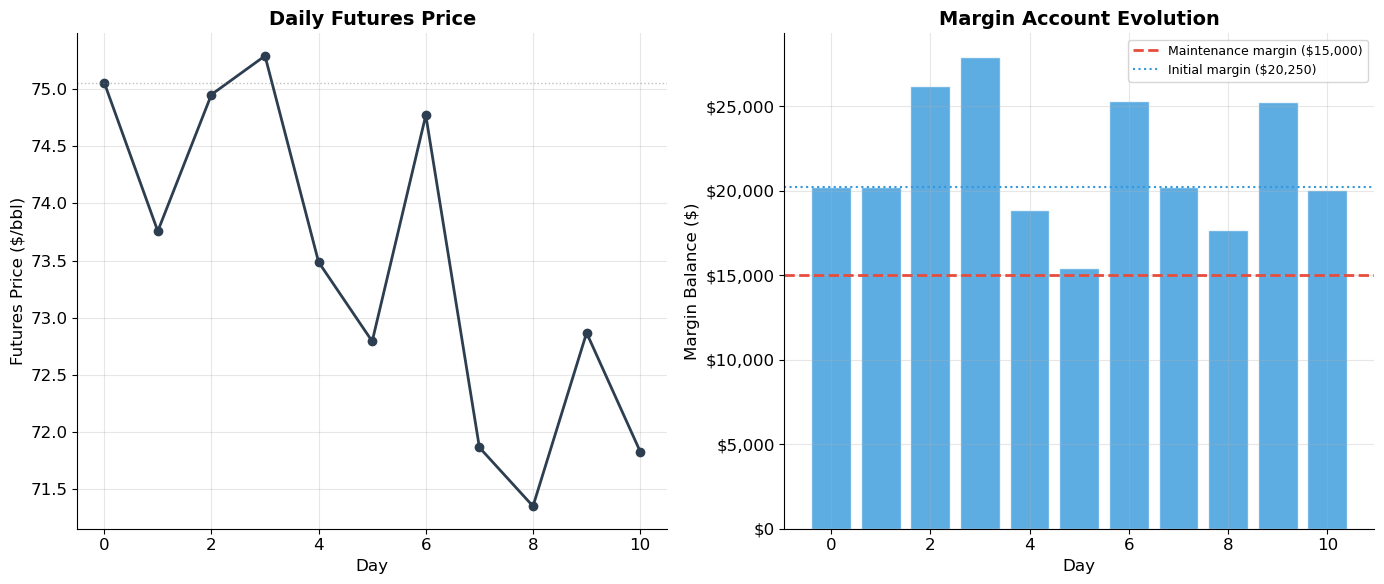

In [11]:
# ============================================================
# Marking to Market — Simulation of a Futures Position
# ============================================================
# ▶ MODIFY AND RE-RUN
F_entry = 75.06        # entry price ($/bbl)
contract_size = 1000   # barrels per contract
n_contracts = 5
initial_margin_per = 4050   # per contract
maint_margin_per = 3000     # per contract
# ============================================================

initial_margin = initial_margin_per * n_contracts
maint_margin = maint_margin_per * n_contracts

# Simulate 10 days of price movements
np.random.seed(123)
daily_changes = np.random.normal(0, 1.2, 10)  # ~$1.20 daily vol
prices = [F_entry]
for dc in daily_changes:
    prices.append(prices[-1] + dc)

print("=" * 85)
print(f"MARKING TO MARKET — {n_contracts} NYMEX Crude Oil Contracts")
print(f"Entry: ${F_entry}/bbl, Contract: {contract_size:,} bbl, Position: {n_contracts*contract_size:,} bbl")
print(f"Initial margin: ${initial_margin:,},  Maintenance margin: ${maint_margin:,}")
print("=" * 85)
print(f"{'Day':>5s} {'Price':>10s} {'Daily Δ':>10s} {'Daily P&L':>12s} {'Cumul P&L':>12s} {'Margin Bal':>12s} {'Status':>15s}")
print("-" * 85)

margin_balance = initial_margin
cumul_pnl = 0
margin_calls = 0

margin_history = [initial_margin]
price_history = [F_entry]
pnl_history = [0]

for day in range(1, len(prices)):
    price_change = prices[day] - prices[day - 1]
    daily_pnl = price_change * contract_size * n_contracts
    cumul_pnl += daily_pnl
    margin_balance += daily_pnl
    
    status = ''
    if margin_balance < maint_margin:
        deposit = initial_margin - margin_balance
        margin_balance = initial_margin
        margin_calls += 1
        status = f'MARGIN CALL +${deposit:,.0f}'
    elif margin_balance < initial_margin * 0.8:
        status = 'Getting close...'
    else:
        status = 'OK'
    
    print(f"{day:>5d} {prices[day]:>10.2f} {price_change:>+10.2f} {daily_pnl:>+12,.0f} {cumul_pnl:>+12,.0f} {margin_balance:>12,.0f} {status:>15s}")
    
    margin_history.append(margin_balance)
    price_history.append(prices[day])
    pnl_history.append(cumul_pnl)

print(f"\nSummary: {margin_calls} margin call(s) over {len(prices)-1} days")
print(f"Final P&L: ${cumul_pnl:+,.0f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

days = range(len(price_history))
ax1.plot(days, price_history, 'o-', color='#2c3e50', linewidth=2, markersize=6)
ax1.axhline(y=F_entry, color='gray', linewidth=1, linestyle=':', alpha=0.5)
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Futures Price ($/bbl)', fontsize=12)
ax1.set_title('Daily Futures Price', fontsize=14, fontweight='bold')

ax2.bar(days, margin_history, color=['#3498db' if m >= maint_margin else '#e74c3c' for m in margin_history],
        alpha=0.8, edgecolor='white')
ax2.axhline(y=maint_margin, color='#e74c3c', linewidth=2, linestyle='--', label=f'Maintenance margin (${maint_margin:,})')
ax2.axhline(y=initial_margin, color='#3498db', linewidth=1.5, linestyle=':', label=f'Initial margin (${initial_margin:,})')
ax2.set_xlabel('Day', fontsize=12)
ax2.set_ylabel('Margin Balance ($)', fontsize=12)
ax2.set_title('Margin Account Evolution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=9)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

---

<a id='5-valuation'></a>
## 5. Valuation — The Cost-of-Carry Model

### The No-Arbitrage Pricing Principle

How is the forward/futures price determined? By the **same no-arbitrage principle** that priced bonds: if two strategies deliver the same outcome, they must cost the same.

**Two ways to own an asset at time $T$:**

| | Strategy A: Forward | Strategy B: Buy and Store |
|---|---|---|
| **Date 0** | Enter forward (cost: \$0) | Buy asset at $S_0$, borrow $S_0$ |
| **Date T** | Pay $F_{0,T}$, receive asset | Own asset, repay $S_0(1+r)^T$ + storage costs |
| **Net cost at T** | $F_{0,T}$ | $S_0(1+r)^T$ + storage − convenience yield |

By no-arbitrage, these must be equal:

$$\boxed{F_{0,T} = S_0(1+r)^T + \text{Storage Costs} - \text{Convenience Yield}}$$

This is the **cost-of-carry model**. The forward price reflects the cost of "carrying" the underlying asset from today to the delivery date.

### Three Cases

**Case 1: Gold** (easy to store, no dividends)

Gold has negligible storage costs and no convenience yield:

$$F_{0,T} = S_0(1+r_f)^T$$

**Case 2: Gasoline** (costly to store, has convenience yield)

$$F_{0,T} = S_0(1 + r_f + c - y)^T$$

where $c$ = storage cost rate and $y$ = convenience yield rate.

**Case 3: Financial assets** (stock indices — no storage cost, pay dividends)

$$F_{0,T} = S_0(1 + r_f - d)^T$$

where $d$ = dividend yield.

In [13]:
# ============================================================
# Cost-of-Carry Pricing Functions
# ============================================================

def forward_price_gold(S0, rf, T):
    """Forward price for gold (no storage, no yield)."""
    return S0 * (1 + rf)**T

def forward_price_commodity(S0, rf, storage, convenience, T):
    """Forward price for commodities with storage costs and convenience yield."""
    return S0 * (1 + rf + storage - convenience)**T

def forward_price_financial(S0, rf, dividend_yield, T):
    """Forward price for financial assets (stock indices)."""
    return S0 * (1 + rf - dividend_yield)**T


# ============================================================
# Lo's Gold Example (Slide 23)
# ============================================================
S0_gold = 267.00   # $/oz, spot price Aug 2, 2001
F_gold = 269.00    # $/oz, October 2001 futures
T_gold = 2/12      # 2 months

# F = S0(1+rf)^T → rf = (F/S0)^(1/T) - 1
rf_implied = (F_gold / S0_gold)**(1/T_gold) - 1

print("=" * 60)
print("GOLD FORWARD PRICING — Lo's Example")
print("=" * 60)
print(f"Spot price (London):       ${S0_gold:.2f}/oz")
print(f"Oct futures (CMX):         ${F_gold:.2f}/oz")
print(f"Time to maturity:          {T_gold:.4f} years (2 months)")
print(f"\nF = S₀(1+r)^T")
print(f"${F_gold:.2f} = ${S0_gold:.2f} × (1+r)^{T_gold:.4f}")
print(f"\nImplied risk-free rate: r = (F/S₀)^(12/2) - 1 = ({F_gold}/{S0_gold})^6 - 1 = {rf_implied:.2%}")

# Verify
F_check = forward_price_gold(S0_gold, rf_implied, T_gold)
print(f"Verification: ${S0_gold:.2f} × (1+{rf_implied:.4f})^{T_gold:.4f} = ${F_check:.2f} ✓")

GOLD FORWARD PRICING — Lo's Example
Spot price (London):       $267.00/oz
Oct futures (CMX):         $269.00/oz
Time to maturity:          0.1667 years (2 months)

F = S₀(1+r)^T
$269.00 = $267.00 × (1+r)^0.1667

Implied risk-free rate: r = (F/S₀)^(12/2) - 1 = (269.0/267.0)^6 - 1 = 4.58%
Verification: $267.00 × (1+0.0458)^0.1667 = $269.00 ✓


In [14]:
# ============================================================
# Lo's Gasoline Example (Slide 24)
# ============================================================
S0_gas = 0.7760    # $/gal spot
F_gas = 0.7330     # $/gal Feb 2002 futures
rf_gas = 0.0340    # 6-month rate
T_gas = 6/12       # 6 months

# F = S0(1 + rf - y)^T → solve for y
# 0.7330 = 0.7760 * (1 + 0.034 - y)^0.5
# (0.7330/0.7760)^2 = 1 + 0.034 - y
# y = 1.034 - (0.7330/0.7760)^2
y_implied = 1 + rf_gas - (F_gas / S0_gas)**(1/T_gas)

print("=" * 60)
print("GASOLINE FORWARD PRICING — Lo's Example")
print("=" * 60)
print(f"Spot price:         ${S0_gas:.4f}/gal")
print(f"Feb 02 futures:     ${F_gas:.4f}/gal")
print(f"6-month rate:       {rf_gas:.2%}")
print(f"\nF = S₀(1 + r - y)^T")
print(f"${F_gas:.4f} = ${S0_gas:.4f} × (1 + {rf_gas:.4f} - y)^0.5")
print(f"\nSolving: y = 1 + r - (F/S₀)^(1/T)")
print(f"         y = 1.034 - ({F_gas}/{S0_gas})^2 = {y_implied:.2%}")
print(f"\nAnnualized net convenience yield: {y_implied:.2%}")
print(f"This is HIGH — gasoline has a large convenience yield because")
print(f"holding physical inventory has real value (fuel for operations).")

# Verify
F_check_gas = S0_gas * (1 + rf_gas - y_implied)**T_gas
print(f"\nVerification: ${S0_gas:.4f} × (1 + {rf_gas:.4f} - {y_implied:.4f})^0.5 = ${F_check_gas:.4f} ✓")

GASOLINE FORWARD PRICING — Lo's Example
Spot price:         $0.7760/gal
Feb 02 futures:     $0.7330/gal
6-month rate:       3.40%

F = S₀(1 + r - y)^T
$0.7330 = $0.7760 × (1 + 0.0340 - y)^0.5

Solving: y = 1 + r - (F/S₀)^(1/T)
         y = 1.034 - (0.733/0.776)^2 = 14.18%

Annualized net convenience yield: 14.18%
This is HIGH — gasoline has a large convenience yield because
holding physical inventory has real value (fuel for operations).

Verification: $0.7760 × (1 + 0.0340 - 0.1418)^0.5 = $0.7330 ✓


In [15]:
# ============================================================
# Lo's S&P 500 Index Futures Example (Slide 25)
# ============================================================
S0_sp = 1220.75    # S&P 500 index level
F_sp = 1233.50     # December futures
rf_sp = 0.035      # T-bill rate
T_sp = 5/12        # approx 5 months to December

# F = S0(1 + rf - d)^T → solve for d
# d = 1 + rf - (F/S0)^(1/T)
d_implied = 1 + rf_sp - (F_sp / S0_sp)**(1/T_sp)

print("=" * 60)
print("S&P 500 INDEX FUTURES — Lo's Example")
print("=" * 60)
print(f"S&P 500 spot:          {S0_sp:.2f}")
print(f"December futures:      {F_sp:.2f}")
print(f"T-bill rate:           {rf_sp:.2%}")
print(f"Time to maturity:      {T_sp:.4f} years (~5 months)")
print(f"\nF = S₀(1 + r - d)^T")
print(f"{F_sp:.2f} = {S0_sp:.2f} × (1 + {rf_sp:.4f} - d)^{T_sp:.4f}")
print(f"\nImplied dividend yield: d = {d_implied:.2%}")

# Verify
F_check_sp = forward_price_financial(S0_sp, rf_sp, d_implied, T_sp)
print(f"Verification: {S0_sp:.2f} × (1+{rf_sp:.4f}-{d_implied:.4f})^{T_sp:.4f} = {F_check_sp:.2f} ✓")

print(f"\nNote: The futures price ({F_sp:.2f}) is ABOVE the spot ({S0_sp:.2f}) because")
print(f"the interest rate ({rf_sp:.1%}) exceeds the dividend yield ({d_implied:.1%}).")
print(f"This is called 'contango'. When d > r, futures < spot ('backwardation').")

S&P 500 INDEX FUTURES — Lo's Example
S&P 500 spot:          1220.75
December futures:      1233.50
T-bill rate:           3.50%
Time to maturity:      0.4167 years (~5 months)

F = S₀(1 + r - d)^T
1233.50 = 1220.75 × (1 + 0.0350 - d)^0.4167

Implied dividend yield: d = 0.97%
Verification: 1220.75 × (1+0.0350-0.0097)^0.4167 = 1233.50 ✓

Note: The futures price (1233.50) is ABOVE the spot (1220.75) because
the interest rate (3.5%) exceeds the dividend yield (1.0%).
This is called 'contango'. When d > r, futures < spot ('backwardation').


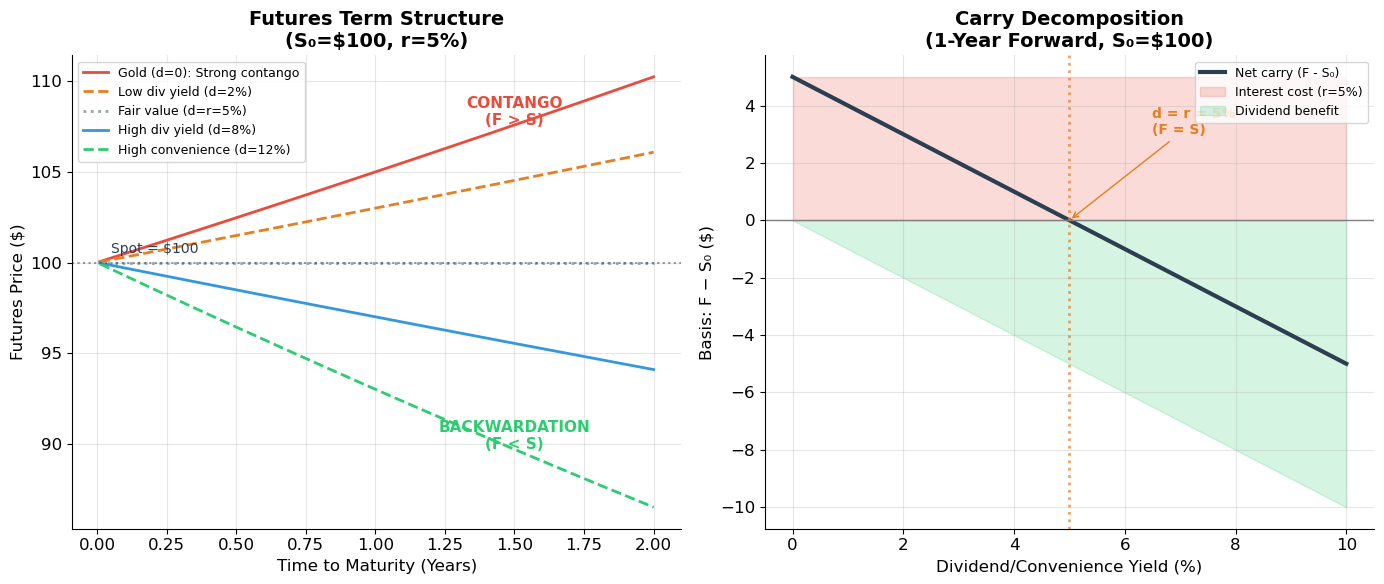

In [16]:
# ============================================================
# Visualization: Contango, Backwardation, and the Term Structure of Futures
# ============================================================
S0 = 100
rf = 0.05
T_range = np.linspace(0.01, 2, 200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Different convenience/dividend yields
for d, color, ls, label in [(0.00, '#e74c3c', '-', 'Gold (d=0): Strong contango'),
                              (0.02, '#e67e22', '--', 'Low div yield (d=2%)'),
                              (0.05, '#95a5a6', ':', 'Fair value (d=r=5%)'),
                              (0.08, '#3498db', '-', 'High div yield (d=8%)'),
                              (0.12, '#2ecc71', '--', 'High convenience (d=12%)')]:
    futures_curve = [forward_price_financial(S0, rf, d, T) for T in T_range]
    ax1.plot(T_range, futures_curve, color=color, linewidth=2, linestyle=ls, label=label)

ax1.axhline(y=S0, color='#2c3e50', linewidth=1.5, linestyle=':', alpha=0.5)
ax1.text(0.05, S0 + 0.5, f'Spot = ${S0}', fontsize=10, color='#2c3e50')
ax1.set_xlabel('Time to Maturity (Years)', fontsize=12)
ax1.set_ylabel('Futures Price ($)', fontsize=12)
ax1.set_title(f'Futures Term Structure\n(S₀=${S0}, r={rf:.0%})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=9, loc='upper left')

# Contango/backwardation labels
ax1.annotate('CONTANGO\n(F > S)', xy=(1.5, forward_price_financial(S0, rf, 0, 1.5)),
            fontsize=11, color='#e74c3c', fontweight='bold', ha='center')
ax1.annotate('BACKWARDATION\n(F < S)', xy=(1.5, forward_price_financial(S0, rf, 0.12, 1.5)),
            fontsize=11, color='#2ecc71', fontweight='bold', ha='center')

# Right: Cost-of-carry decomposition
T_example = 1  # 1 year
d_range = np.linspace(0, 0.10, 200)
F_values = [forward_price_financial(S0, rf, d, T_example) for d in d_range]

interest_component = np.full_like(d_range, S0 * rf * T_example)
dividend_component = S0 * d_range * T_example

ax2.plot(d_range * 100, np.array(F_values) - S0, color='#2c3e50', linewidth=3,
         label='Net carry (F - S₀)')
ax2.fill_between(d_range * 100, 0, S0 * rf, alpha=0.2, color='#e74c3c', label=f'Interest cost (r={rf:.0%})')
ax2.fill_between(d_range * 100, 0, -S0 * d_range, alpha=0.2, color='#2ecc71', label='Dividend benefit')

ax2.axhline(y=0, color='gray', linewidth=1)
ax2.axvline(x=rf * 100, color='#e67e22', linewidth=2, linestyle=':', alpha=0.7)
ax2.annotate(f'd = r = {rf:.0%}\n(F = S)', xy=(rf*100, 0), xytext=(rf*100 + 1.5, 3),
            fontsize=10, color='#e67e22', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#e67e22'))

ax2.set_xlabel('Dividend/Convenience Yield (%)', fontsize=12)
ax2.set_ylabel('Basis: F − S₀ ($)', fontsize=12)
ax2.set_title('Carry Decomposition\n(1-Year Forward, S₀=$100)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.show()

---

<a id='7-hedging'></a>
## 7. Hedging with Index Futures

### Creating a Synthetic Index Fund

Lo gives a simple example (Slide 27): You have \$1M to invest in the S&P 500.

**Method 1: Buy stocks.** Purchase all 500 stocks weighted by market cap — expensive and complex.

**Method 2: Buy S&P futures.** Deposit \$1M in your margin account. If the S&P is at 1,000, and each futures contract is worth \$250 × index:

$$\text{Number of contracts} = \frac{\$1{,}000{,}000}{\$250 \times 1{,}000} = 4 \text{ contracts}$$

The futures replicate the equity exposure with much lower transaction costs.

### Partial Hedging

You hold a \$5M diversified portfolio of large-cap stocks and want to reduce exposure by 25%. Instead of selling \$1.25M of stocks (incurring commissions, taxes, market impact):

**Short-sell 5 S&P 500 futures contracts.**

This creates a portfolio that behaves as if 25% has been shifted to cash — reducing market exposure without touching the underlying stocks.

In [18]:
# ============================================================
# Hedging with S&P 500 Index Futures — Lo's Example
# ============================================================
# ▶ MODIFY AND RE-RUN
portfolio_value = 5_000_000     # $5M portfolio
sp500_current = 1000            # current index level
futures_multiplier = 250        # $250 per index point
hedge_fraction = 0.25           # reduce 25% exposure
contract_value = futures_multiplier * sp500_current   # $250,000 per contract
n_hedge_contracts = int(portfolio_value * hedge_fraction / contract_value)
# ============================================================

print("=" * 70)
print("HEDGING WITH S&P 500 FUTURES — Lo's Example")
print("=" * 70)
print(f"Portfolio value:           ${portfolio_value:>12,}")
print(f"S&P 500:                   {sp500_current:>12,}")
print(f"Futures multiplier:        ${futures_multiplier:>12,}")
print(f"Value per contract:        ${contract_value:>12,}")
print(f"Hedge fraction:            {hedge_fraction:>12.0%}")
print(f"Contracts to short:        {n_hedge_contracts:>12,}")

# Scenario analysis
sp_changes = np.array([-0.20, -0.10, -0.05, 0.00, 0.05, 0.10, 0.20])
sp_new = sp500_current * (1 + sp_changes)

print(f"\n{'S&P Change':>12s} {'Unhedged':>12s} {'Futures P&L':>13s} {'Hedged':>12s} {'Hedged Chg':>12s}")
print("-" * 65)
for chg, sp_n in zip(sp_changes, sp_new):
    unhedged = portfolio_value * (1 + chg)
    futures_pnl = -n_hedge_contracts * futures_multiplier * (sp_n - sp500_current)  # short position
    hedged = unhedged + futures_pnl
    hedged_chg = (hedged / portfolio_value - 1)
    print(f"{chg:>+12.0%} ${unhedged/1e6:>11.2f}M ${futures_pnl/1e6:>+12.3f}M ${hedged/1e6:>11.2f}M {hedged_chg:>+12.1%}")

print(f"\n→ Hedged portfolio change ≈ {1-hedge_fraction:.0%} × market move")
print(f"  As if {hedge_fraction:.0%} of the portfolio was shifted to cash.")

HEDGING WITH S&P 500 FUTURES — Lo's Example
Portfolio value:           $   5,000,000
S&P 500:                          1,000
Futures multiplier:        $         250
Value per contract:        $     250,000
Hedge fraction:                     25%
Contracts to short:                   5

  S&P Change     Unhedged   Futures P&L       Hedged   Hedged Chg
-----------------------------------------------------------------
        -20% $       4.00M $      +0.250M $       4.25M       -15.0%
        -10% $       4.50M $      +0.125M $       4.62M        -7.5%
         -5% $       4.75M $      +0.062M $       4.81M        -3.7%
         +0% $       5.00M $      -0.000M $       5.00M        +0.0%
         +5% $       5.25M $      -0.062M $       5.19M        +3.8%
        +10% $       5.50M $      -0.125M $       5.38M        +7.5%
        +20% $       6.00M $      -0.250M $       5.75M       +15.0%

→ Hedged portfolio change ≈ 75% × market move
  As if 25% of the portfolio was shifted to cash.


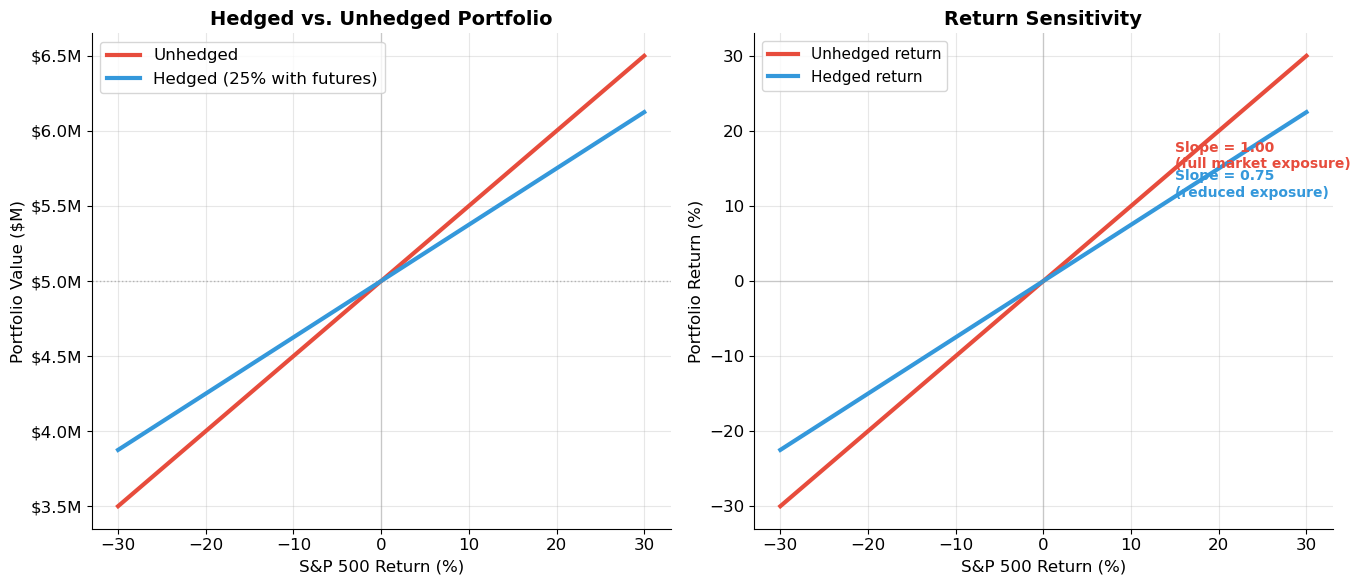

Futures hedging reduces BOTH downside AND upside by the hedge fraction.
It's not 'free insurance' — you give up upside to reduce downside.
This is fundamentally different from options (Session 8), which can
protect the downside while preserving the upside — but at a cost.


In [19]:
# ============================================================
# Visualization: Hedged vs. Unhedged Portfolio
# ============================================================
sp_returns = np.linspace(-0.30, 0.30, 200)
unhedged = portfolio_value * (1 + sp_returns)
futures_pnl = -n_hedge_contracts * futures_multiplier * sp500_current * sp_returns
hedged = unhedged + futures_pnl

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Portfolio values
ax1.plot(sp_returns * 100, unhedged / 1e6, color='#e74c3c', linewidth=3, label='Unhedged')
ax1.plot(sp_returns * 100, hedged / 1e6, color='#3498db', linewidth=3, label=f'Hedged ({hedge_fraction:.0%} with futures)')
ax1.axhline(y=portfolio_value / 1e6, color='gray', linewidth=1, linestyle=':', alpha=0.5)
ax1.axvline(x=0, color='gray', linewidth=1, alpha=0.3)

ax1.set_xlabel('S&P 500 Return (%)', fontsize=12)
ax1.set_ylabel('Portfolio Value ($M)', fontsize=12)
ax1.set_title('Hedged vs. Unhedged Portfolio', fontsize=14, fontweight='bold')
ax1.legend(fontsize=12)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:.1f}M'))

# Right: Return distribution comparison
ax2.plot(sp_returns * 100, sp_returns * 100, color='#e74c3c', linewidth=3, label='Unhedged return')
ax2.plot(sp_returns * 100, (hedged / portfolio_value - 1) * 100, color='#3498db', linewidth=3,
         label=f'Hedged return')
ax2.axhline(y=0, color='gray', linewidth=1, alpha=0.3)
ax2.axvline(x=0, color='gray', linewidth=1, alpha=0.3)

# Show slope difference
ax2.annotate(f'Slope = 1.00\n(full market exposure)', xy=(15, 15),
            fontsize=10, color='#e74c3c', fontweight='bold')
ax2.annotate(f'Slope = {1-hedge_fraction:.2f}\n(reduced exposure)', xy=(15, 15*(1-hedge_fraction)),
            fontsize=10, color='#3498db', fontweight='bold')

ax2.set_xlabel('S&P 500 Return (%)', fontsize=12)
ax2.set_ylabel('Portfolio Return (%)', fontsize=12)
ax2.set_title('Return Sensitivity', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("Futures hedging reduces BOTH downside AND upside by the hedge fraction.")
print("It's not 'free insurance' — you give up upside to reduce downside.")
print("This is fundamentally different from options (Session 8), which can")
print("protect the downside while preserving the upside — but at a cost.")

---

<a id='6-applications'></a>
## 6. Extensions and Qualifications

### Forward vs. Futures Prices

In theory, forward and futures prices differ slightly due to marking-to-market. The difference depends on the **correlation between interest rates and futures prices**:

- If positively correlated: futures price > forward price (daily gains can be reinvested at higher rates)
- If negatively correlated: futures price < forward price
- In practice, the difference is usually small and often ignored

### Other Important Futures Markets

| Market | Exchange | Examples |
|--------|----------|----------|
| **Interest rate** | CME, CBOT | Eurodollar futures, T-bond futures |
| **Currency** | CME | EUR/USD, JPY/USD futures |
| **Equity index** | CME | S&P 500, NASDAQ, Nikkei |
| **Commodity** | NYMEX, CME | Crude oil, gold, agricultural |
| **Single stock** | OneChicago | Individual stock futures |
| **Volatility** | CBOE | VIX futures |

### The Basis

The **basis** is the difference between the spot price and the futures price:

$$\text{Basis} = S_t - F_{t,T}$$

As maturity approaches, the basis **converges to zero** (the futures price must equal the spot price at delivery). This convergence is enforced by arbitrage.

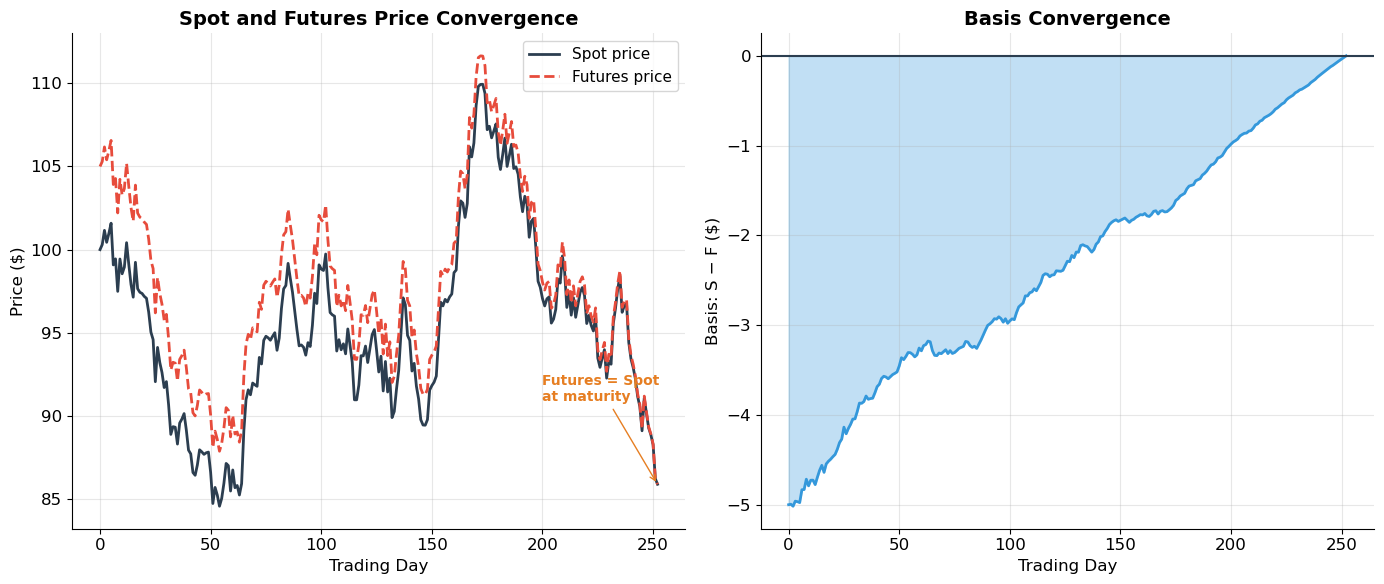

The basis starts negative (contango: F > S due to carrying cost),
and converges to zero at maturity. This convergence is guaranteed
by no-arbitrage: at delivery, F must equal S.


In [21]:
# ============================================================
# Basis Convergence as Maturity Approaches
# ============================================================
S0 = 100
rf = 0.05
T_total = 1.0  # 1 year
n_days = 252

# Simulate spot price (GBM)
np.random.seed(77)
dt = T_total / n_days
spot_path = [S0]
for _ in range(n_days):
    dS = spot_path[-1] * (rf * dt + 0.20 * np.sqrt(dt) * np.random.normal())
    spot_path.append(spot_path[-1] + dS)

# Futures price at each point: F_t = S_t * (1+rf)^(T-t)
times = np.linspace(0, T_total, n_days + 1)
remaining = T_total - times
futures_path = [S * (1 + rf)**rem for S, rem in zip(spot_path, remaining)]
basis = [S - F for S, F in zip(spot_path, futures_path)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Spot and futures converge
ax1.plot(times * 252, spot_path, color='#2c3e50', linewidth=2, label='Spot price')
ax1.plot(times * 252, futures_path, color='#e74c3c', linewidth=2, linestyle='--', label='Futures price')
ax1.set_xlabel('Trading Day', fontsize=12)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title('Spot and Futures Price Convergence', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)

# Annotate convergence
ax1.annotate('Futures = Spot\nat maturity',
            xy=(252, spot_path[-1]), xytext=(200, spot_path[-1] + 5),
            fontsize=10, fontweight='bold', color='#e67e22',
            arrowprops=dict(arrowstyle='->', color='#e67e22'))

# Right: Basis shrinks to zero
ax2.fill_between(times * 252, 0, basis, alpha=0.3, color='#3498db')
ax2.plot(times * 252, basis, color='#3498db', linewidth=2)
ax2.axhline(y=0, color='#2c3e50', linewidth=1.5)
ax2.set_xlabel('Trading Day', fontsize=12)
ax2.set_ylabel('Basis: S − F ($)', fontsize=12)
ax2.set_title('Basis Convergence', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("The basis starts negative (contango: F > S due to carrying cost),")
print("and converges to zero at maturity. This convergence is guaranteed")
print("by no-arbitrage: at delivery, F must equal S.")

---

<a id='8-exercises'></a>
## 8. Exercises

### Exercise 1: Forward Pricing

**(a)** Gold is trading at \$1,850/oz. The 1-year risk-free rate is 4%. What is the theoretical 1-year gold forward price?

**(b)** The actual 1-year gold futures price is \$1,900. Is there an arbitrage? If so, describe the strategy and calculate the profit per ounce.

**(c)** Silver trades at \$24/oz. Storage costs are 1% per year (of the silver value). The risk-free rate is 4%. What is the 6-month forward price?

**(d)** Crude oil trades at \$70/bbl. The 6-month futures price is \$68/bbl. The risk-free rate is 5%. Compute the implied net convenience yield. Why might oil have a positive convenience yield?

In [23]:
# Exercise 1 — Workspace
# (a) F = S0 * (1+r)^T = 1850 * 1.04 = ?
#
# (b) If F_actual = 1900 > F_theoretical:
# Cash-and-carry arbitrage:
# 1. Borrow $1850, buy gold
# 2. Short the forward at $1900
# 3. At T=1: deliver gold, receive $1900, repay $1850*1.04
# Profit = 1900 - 1850*1.04 = ?
#
# (c) F = S0 * (1+r+c)^T = 24 * (1+0.04+0.01)^0.5 = ?
#
# (d) 68 = 70 * (1 + 0.05 - y)^0.5 → solve for y

### Exercise 2: Marking to Market

You go long 3 gold futures contracts at \$1,850/oz. Each contract is for 100 oz. Initial margin is \$10,000 per contract. Maintenance margin is \$7,500 per contract.

Over the next 5 days, gold settles at: \$1,842, \$1,836, \$1,851, \$1,860, \$1,855.

**(a)** Construct the daily margin account table showing settlement price, daily P&L, cumulative P&L, margin balance, and any margin calls.

**(b)** Calculate the total profit/loss over the 5-day period. How much total cash did you need (including margin calls)?

**(c)** What is the maximum drawdown? At what price would you have received your first margin call if prices moved straight down from entry?

In [25]:
# Exercise 2 — Workspace
# contracts = 3
# oz_per_contract = 100
# entry = 1850
# init_margin = 10000 * 3
# maint_margin = 7500 * 3
# settlements = [1842, 1836, 1851, 1860, 1855]
#
# margin = init_margin
# for day, price in enumerate(settlements, 1):
#     pnl = (price - prev_price) * oz_per_contract * contracts
#     margin += pnl
#     if margin < maint_margin:
#         deposit = init_margin - margin
#         margin = init_margin
#         print(f"Day {day}: MARGIN CALL, deposit ${deposit:,.0f}")

### Exercise 3: Hedging and Speculation

**(a)** A wheat farmer expects to harvest 50,000 bushels in 3 months. Wheat futures for 3-month delivery are at \$5.50/bushel (contract size: 5,000 bushels). Design a hedge. What are the possible outcomes if wheat prices move to \$4.80 or \$6.20?

**(b)** You hold \$10M in a portfolio that tracks the S&P 500. The S&P is at 5,000 and futures are at 5,025 (multiplier: \$50). How many contracts would you short to hedge 50% of your market exposure? Show the hedged portfolio value for ±10% and ±20% market moves.

**(c)** An oil refiner needs to buy 100,000 barrels of crude oil in 3 months. She can either (i) buy crude futures now, or (ii) wait and buy at the spot price. Current spot is \$72/bbl, 3-month futures are \$73/bbl, and the risk-free rate is 5%. The refiner's CFO says "futures are overpriced — just wait and buy spot." Is the CFO correct? Explain using the cost-of-carry model.

**(d)** You believe the stock market will decline over the next 6 months. You have \$50,000 in your account. S&P 500 futures (multiplier \$250) are at 5,000. How many contracts can you short if initial margin is 10% of contract value? What is your percentage return if the S&P drops to 4,500? What if it rises to 5,200? Comment on the leverage.

In [27]:
# Exercise 3 — Workspace
# (a) Wheat hedge
# n_contracts = 50000 / 5000  # = 10 contracts, SHORT
# At $4.80: spot loss = (4.80-5.50)*50000, futures gain = (5.50-4.80)*50000
# At $6.20: spot gain = (6.20-5.50)*50000, futures loss = (5.50-6.20)*50000
#
# (b) Index hedge
# contract_value = 50 * 5000  # = $250,000
# hedge_contracts = int(10_000_000 * 0.50 / contract_value)
#
# (d) Speculation
# contract_value = 250 * 5000  # = $1,250,000
# margin_per = 0.10 * contract_value  # = $125,000
# n_contracts = 50000 // margin_per  # can you afford even 1?
# Think about this: $50K margin vs $1.25M exposure = 25x leverage

---

## Key Takeaways — Session 7

1. **Forward contracts** are private agreements to exchange an asset at a future date for a price fixed today. They are customized, OTC, and carry counterparty risk.

2. **Futures contracts** solve the limitations of forwards through standardization, exchange trading, daily marking-to-market, and clearing house guarantees.

3. **No-arbitrage pricing:** The forward/futures price is determined by the **cost of carry** — the cost of financing + storage minus income from holding the asset:
   - Gold: $F = S_0(1+r)^T$
   - Commodities: $F = S_0(1+r+c-y)^T$
   - Financial assets: $F = S_0(1+r-d)^T$

4. **Contango** ($F > S$) occurs when carrying costs exceed income. **Backwardation** ($F < S$) occurs when convenience yield or dividends dominate.

5. **The basis** ($S - F$) converges to zero at maturity, enforced by arbitrage.

6. **Hedging with futures** reduces both downside and upside by the hedge fraction. It is NOT free insurance — you trade potential gains for certainty.

7. **Leverage:** Futures require only margin (5–20% of contract value), amplifying both gains and losses. This makes futures powerful but dangerous for undercapitalized speculators.

---

## References

- **Brealey, R.A., Myers, S.C., and Allen, F.** *Principles of Corporate Finance*, Chapter 27.
- **MIT OCW 15.401:** [Forward and Futures Contracts](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/forward-and-futures-contracts/)
- **Guay, W. and Kothari, S.** (2003). "How Much Do Firms Hedge with Derivatives?" *Journal of Financial Economics*, 70, 423–461.
- **Siegel, D. and Siegel, D.** (1990). *The Futures Market: Arbitrage, Risk Management, and Portfolio Strategies*. Dryden Press.

---

*Next: **Session 8 — Options** — call and put options, payoff diagrams, put-call parity, the binomial model, and an introduction to Black-Scholes.*